In [1]:
# Data
import numpy as np
import pandas as pd

# Plots
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [2]:
SEED = 60
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
with np.load('../data/training-dataset.npz') as data:
    img = data['x']
    lbl = data['y']

In [4]:
def convert_label(label):
    '''Returns the letter that is associated with the label'''
    return chr(label+64)

In [5]:
def plot_image(image, label=False):
    '''Displays the image associated with the input index'''  
    fig, ax = plt.subplots(figsize=(3,3), facecolor='w')
    
    ax.imshow(image.reshape(28,28), cmap='binary')
    ax.axis('off')
    
    if label:
        image_label = convert_label(label)
        ax.set_title(f'Label: {image_label}', fontsize=20)
    
    plt.show()

## Convolutional Neural Network

### Pre-process data

In [6]:
def preprocess_images(img, num_images, image_size):
    '''Returns normalized and reshaped image'''
    img = tf.keras.utils.normalize(img, axis=1)
    img = img.reshape(num_images, image_size[0], image_size[1], 1)
    return img

def preprocess_labels(lbl, num_classes):
    '''Returns encoded labels'''
    lbl = tf.keras.utils.to_categorical(lbl-1, num_classes)
    return lbl             

In [7]:
num_images = len(img)
image_size = int(np.sqrt(img[0].size))
num_classes = len(np.unique(lbl))

X = preprocess_images(img, num_images, (image_size, image_size))
y = preprocess_labels(lbl, num_classes)
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (124800, 28, 28, 1)
y shape: (124800, 26)


In [8]:
# Split train and test data
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.15, random_state=SEED)

In [9]:
# Split train data into training and validations sets
BATCH_SIZE = 64

data_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=.15)

training_data_generator = data_generator.flow(X_train,
                                              y_train,
                                              subset='training',
                                              batch_size=BATCH_SIZE,
                                              seed=SEED)

validation_data_generator = data_generator.flow(X_train,
                                                y_train,
                                                subset='validation',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED)

### Build model

In [10]:
def build_cnn_model():
    model = tf.keras.Sequential([
        Input(shape=(image_size, image_size, 1)),
        Conv2D(64, 5, strides=2, padding='same'),
        LeakyReLU(),
        Conv2D(32, 2, strides=1, padding='same'),
        LeakyReLU(),
        MaxPooling2D(pool_size=2, strides=1),
        Dropout(0.5, seed=SEED),

        Input(shape=(image_size, image_size, 1)),
        Conv2D(64, 5, strides=2, padding='same'),
        LeakyReLU(),
        Conv2D(32, 2, strides=1, padding='same'),
        LeakyReLU(),
        MaxPooling2D(pool_size=2, strides=1),
        Dropout(0.5, seed=SEED),

        Flatten(),
        Dense(128),
        LeakyReLU(),
        Dropout(0.3, seed=SEED),
        Dense(128),
        LeakyReLU(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model 

model = build_cnn_model()    
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
input_2 (InputLayer)         multiple                  0

### Train model

In [11]:
# Set callbacks
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3,
                              factor=0.1, min_lr=0.00001)


# Train model
def train_cnn(model, epochs):
    history = model.fit(training_data_generator,
                        epochs=epochs,
                        validation_data=validation_data_generator,
                        callbacks=[early_stopping, reduce_lr])

    _, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
    print('Model accuracy:', test_acc)
    return history


EPOCHS = 20
history = train_cnn(model, EPOCHS)

Epoch 1/20
1409/1409 [==============================] - 10s 7ms/step - loss: 0.7626 - accuracy: 0.7601 - val_loss: 0.3029 - val_accuracy: 0.9001 - lr: 0.0010
Epoch 2/20
1409/1409 [==============================] - 10s 7ms/step - loss: 0.3723 - accuracy: 0.8773 - val_loss: 0.2421 - val_accuracy: 0.9172 - lr: 0.0010
Epoch 3/20
1409/1409 [==============================] - 9s 7ms/step - loss: 0.3115 - accuracy: 0.8970 - val_loss: 0.2244 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/20
1409/1409 [==============================] - 9s 7ms/step - loss: 0.2856 - accuracy: 0.9043 - val_loss: 0.2126 - val_accuracy: 0.9264 - lr: 0.0010
Epoch 5/20
1409/1409 [==============================] - 9s 7ms/step - loss: 0.2648 - accuracy: 0.9108 - val_loss: 0.2011 - val_accuracy: 0.9303 - lr: 0.0010
Epoch 6/20
1409/1409 [==============================] - 9s 7ms/step - loss: 0.2552 - accuracy: 0.9138 - val_loss: 0.1954 - val_accuracy: 0.9343 - lr: 0.0010
Epoch 7/20
1409/1409 [==============================] - 

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print('Model accuracy:', test_acc)

293/293 [==============================] - 1s 3ms/step - loss: 0.1510 - accuracy: 0.9507
Model accuracy: 0.9506944417953491


### Save Model

In [13]:
def save_model(file_name):
    model_json = model.to_json()
    with open(f'../models/{file_name}.json', 'w') as f:
        f.write(model_json)
    model.save_weights(f'../models/{file_name}.h5')
    print(f'Model saved as {file_name}.')
    
save_model('cnn')

Model saved as cnn.


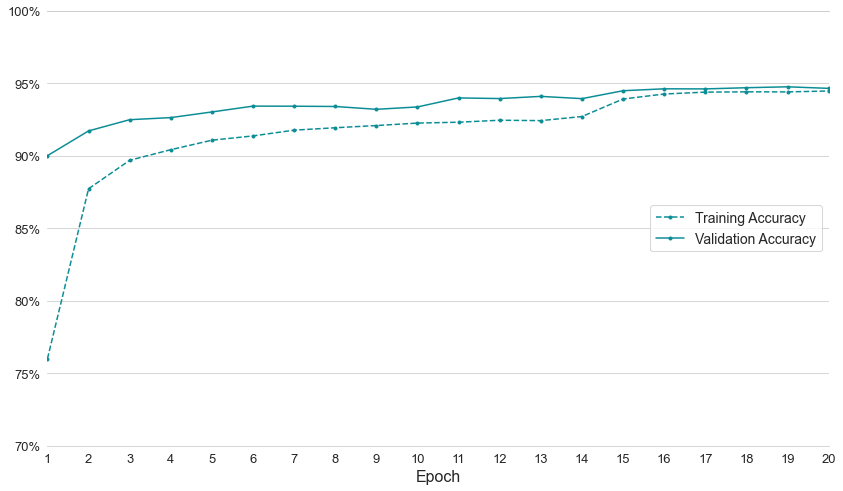

In [14]:
# Plot model history

sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(14, 8), facecolor='w')
(pd.DataFrame(history.history)
      [['accuracy', 'val_accuracy']]
      .plot(ax=ax,
            style=['--', '-', '-'],
            color=['#0c8d96', '#0c8d96'],
            marker='.'))

# Titles and labels
plt.xlabel(r'Epoch', fontsize=16)
ax.legend(['Training Accuracy', 'Validation Accuracy'],
            loc=5, fontsize=14)

plt.grid(axis='x')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Limits
num_epochs = len(history.history['accuracy'])
plt.xlim(0, num_epochs-1)
plt.ylim(.7, 1)

# Set ticks
plt.xticks(range(0, num_epochs), labels=range(1, num_epochs+1), fontsize=13)
y_ticks = np.arange(0.7, 1.0, 0.05)
plt.yticks(y_ticks, labels=[f'{l:.0%}' for l in y_ticks], fontsize=13)

plt.show()

#### Load Model

In [15]:
def load_model(model_name):
    with open (f'../models/{model_name}.json') as json_file:
        model_json = json_file.read()
        model = model_from_json(model_json)

    model.load_weights(f'../models/{model_name}.h5')
    print(f'Model {model_name} loaded.')
    return model

model = load_model('cnn')

Model cnn loaded.


## Evaluate

#### Confusion Matrix

In [16]:
    y_test_lbl = np.argmax(y_test, axis=1)
    y_pred_lbl = np.argmax(model.predict(X_test), axis=1)

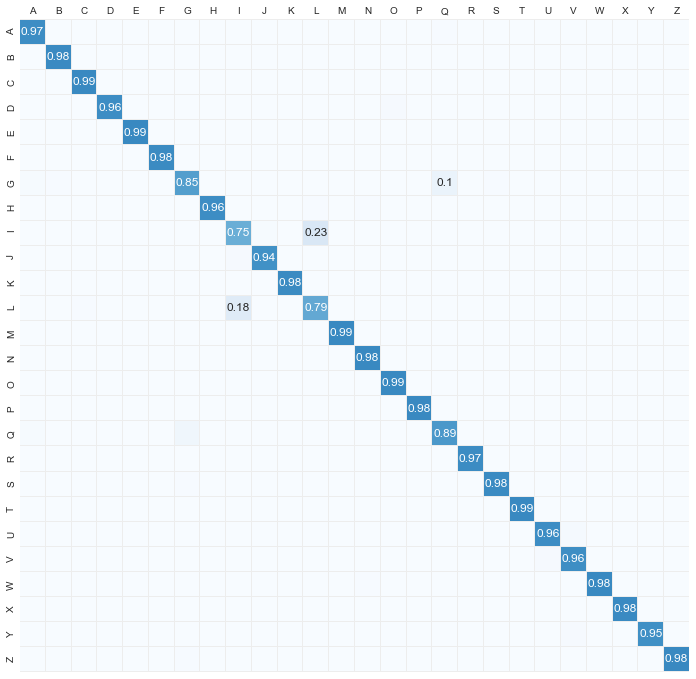

In [17]:
cm = np.zeros((26, 26))
for t, p in zip(y_test_lbl, y_pred_lbl):
    cm[t,p] += 1
cm = cm/cm.sum(axis=1)  # Convert to percentages

# Custom annotation
annot = cm/cm.sum(axis=1)
annot = annot.round(2)
annot[annot < 0.1] = 0.00
annot = annot.astype('str')
annot[annot == '0.0'] = ''

fig, ax = plt.subplots(figsize=(12, 12), facecolor='w')
g = sns.heatmap(cm, ax=ax, cmap='Blues', center=0.75, cbar=False,
                linecolor='#ededed', linewidths=.005,
                annot=annot, fmt='', annot_kws={'fontsize': 12})

# X ticks to top
g.xaxis.set_ticks_position('top')
g.tick_params(axis='both', which='both', length=0)

# Change labels to letters
g.set_xticklabels(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))
g.set_yticklabels(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))

plt.show()

#### Predict Images

In [18]:
wrong_predictions = y_test_lbl != y_pred_lbl
X_test_wrong = X_test[wrong_predictions]
y_test_wrong = y_test_lbl[wrong_predictions]

In [19]:
pd.Series([convert_label(y+1) for y in y_test_wrong]).value_counts().sort_index().to_frame('Misclassified').T

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
Misclassified,24,14,9,26,10,17,107,28,178,41,...,78,23,17,11,27,29,12,14,38,13


In [20]:
def show_prediction(image):
    prediction = model.predict(image.reshape(1,28,28,1))
    
    order = np.argsort(prediction[0])
    percentages = sorted(prediction[prediction >= 0.01], reverse=True)

    letters = [convert_label(l+1) for l in order]
    predicted_letters = letters[::-1][:len(percentages)]

    title_text = []
    for p, l in zip(percentages, predicted_letters):
        title_text.append(f'{l}: {p*100:.2f}%')

    fig, ax = plt.subplots(facecolor='w')
    ax.imshow(image.reshape(28,28), cmap='binary')
    ax.set_title('\n'.join(title_text), fontsize=18)
    ax.axis('off')
    
    plt.show()

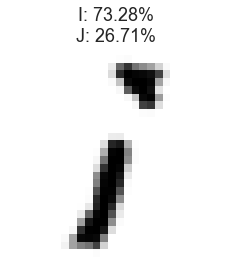

In [21]:
image = X_test_wrong[100]
show_prediction(image)

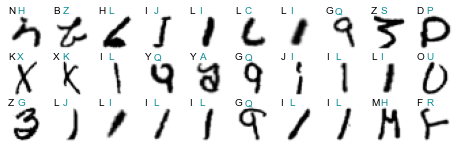

In [22]:
np.random.seed(42)

# Grid of random wrong predictions
ROWS, COLS = 3, 10

fig, axes = plt.subplots(ROWS, COLS,
                         figsize=(COLS*0.8, ROWS*0.8),
                         facecolor='w')

for i in range(ROWS):
    for j in range(COLS):
        index = np.random.randint(len(X_test_wrong))
        image = X_test_wrong[index].reshape(28,28)
      
        prediction = np.argmax(model.predict(image.reshape(1,28,28,1)))
        actual_label = convert_label(y_test_wrong[index]+1)
        predicted_label = convert_label(prediction+1)

        axes[i,j].imshow(image, cmap='binary')
        axes[i,j].text(0, 0, actual_label, c='k')
        axes[i,j].text(7, 0, predicted_label, c='#0c8d96')
        axes[i,j].axis('off')

plt.savefig('../figures/cnn_wrong_predictions.png', dpi=300 , bbox_inches='tight')
plt.show()